In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from deepchem import metrics
import deepchem as dc
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from sklearn.model_selection import GridSearchCV


## Importing and splitting the data

In [2]:
bbb_df = pd.read_csv('adenot_processed.csv')
bbb_df.head()

,Drug,SMILES,permeable,0,1,2,3,4,5,6,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,ACEBUTOLOL,CCCC(=O)Nc1ccc(c(c1)C(C)=O)OCC(O)CNC(C)C,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,DACTINOMYCIN,CC(C)[C@H]1NC(=O)[C@@H](NC(=O)c2ccc(c3c2N=C2C(...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,ALDOSTERONE,C[C@@]12CCC(=O)C=C2CC[C@H]2C3CC[C@H](C(=O)CO)C...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,AMILORIDE,N\C(=N)\NC(=O)c1nc(c(nc1N)N)Cl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,AMIODARONE,CCCCc1oc2ccccc2c1C(=O)c1cc(c(c(c1)[I])OCCN(CC)...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
X = bbb_df.drop(columns=["Drug", "SMILES", 'permeable'])
Y = bbb_df['permeable']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

## Building and training the model

In [6]:
SVM = SVC().fit(X_train, y_train)

train_prediction = SVM.predict(X_train)
test_prediction = SVM.predict(X_test)

#### Hyperparameter Optimization

In [9]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['linear']}


In [10]:
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.3s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.4s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.3s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.3s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.3s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.3s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.3s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.3s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.3s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.3s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   0.3s
[CV] END ...................C=0.1, gamma=0.01, k

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['linear']},
             verbose=2)

In [11]:
print(grid.best_params_)


{'C': 0.1, 'gamma': 1, 'kernel': 'linear'}


#### Optimized SVM

In [12]:
SVM_best = SVC(C=0.1, gamma=1, kernel='linear', probability=True).fit(X_train, y_train)

In [13]:
SVM_best.fit(X_train, y_train)
# make predictions for test data
y_pred = SVM_best.predict(X_test)

#### Feature Importances

In [15]:
# get importance
dt_importance = SVM_best.coef_

# summarize and print out the feature importance
non_zero_index_list = [i for i, v in enumerate(dt_importance[0]) if v != 0]

# remove all zero value entries
non_zero_feature_names = [bbb_df.iloc[:,3:].columns[i] for i in non_zero_index_list]
non_zero_importance = [dt_importance[0][i] for i in non_zero_index_list]
non_zero_feature_names_str = [str(x) for x in non_zero_feature_names]
feature_importance = pd.DataFrame(list(zip(non_zero_feature_names_str, non_zero_importance)), columns =['Feature','Importance'])
feature_importance.sort_values(by='Importance', ascending=True, inplace=True)

In [16]:
feature_importance.tail(5)

,Feature,Importance
755,767,0.202917
404,412,0.214317
771,784,0.224616
783,798,0.224833
134,138,0.278872


Text(0.5, 1.0, 'Top 10 SVM Feature Importances')

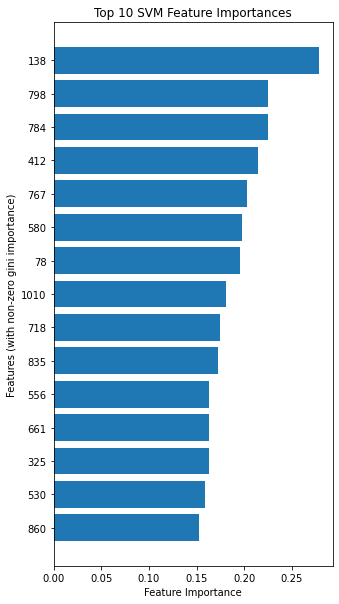

In [17]:
fig,ax = plt.subplots(figsize=(5,10))
plt.xlabel('Feature Importance')
plt.ylabel('Features (with non-zero gini importance)')
plt.barh(feature_importance['Feature'][990:], feature_importance['Importance'][990:])
plt.title('Top 10 SVM Feature Importances')

### Random Split PCA, DR, and Result Metrics

/opt/anaconda3/envs/bme590/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/envs/bme590/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Random Split Metrics:
Accuracy: 0.9640718562874252
Balanced Accuracy: 0.9212593516209476
ROC AUC: 0.9212593516209476
Precision Score: 0.9636803874092009
Recall Score: 0.9925187032418953



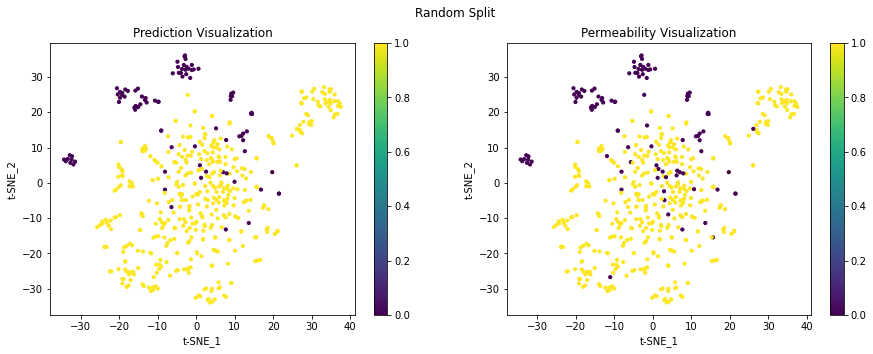

In [18]:
def plot_split(split, y_pred, y_test, t_components):
    
    fig = plt.figure(figsize=(15, 5))
    fig.suptitle('{} Split'.format(split))
    plt.subplot(1, 2, 1)
    plt.scatter(t_components[:,0], t_components[:,1], c=y_pred, s=10)
    plt.xlabel('t-SNE_1')
    plt.ylabel('t-SNE_2')
    plt.title('Prediction Visualization')
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.scatter(t_components[:,0], t_components[:,1], c=y_test,s=10)
    plt.xlabel('t-SNE_1')
    plt.ylabel('t-SNE_2')
    plt.title('Permeability Visualization')
    plt.colorbar()
    
    # Calculate how often the classifier is correct
    print("{} Split Metrics:".format(split))
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("Balanced Accuracy:", metrics.balanced_accuracy_score(y_test, y_pred))
    print("ROC AUC:", metrics.roc_auc_score(y_test, y_pred))
    print("Precision Score:", metrics.precision_score(y_test, y_pred))
    print("Recall Score:", metrics.recall_score(y_test, y_pred))
    print("")

dim = 100
pca_rand = PCA(n_components=dim)
components_rand = pca_rand.fit_transform(X_test)
tsne_rand = TSNE(n_components=2)
t_components_rand = tsne_rand.fit_transform(components_rand)

plot_split('Random', y_pred, y_test, t_components_rand)


### Scaffold Split 

#### Data preprocessing

In [19]:
Xs = bbb_df.iloc[:,3:].copy()
Ys = bbb_df.iloc[:,2].copy()
dataset = dc.data.DiskDataset.from_numpy(X=Xs,y=Ys,ids=bbb_df['SMILES'].tolist())
scaffoldsplitter = dc.splits.ScaffoldSplitter()
train_scaff, test_scaff = scaffoldsplitter.train_test_split(dataset)

### Model Predictions (Classes and Probabilities)

In [20]:
# Train SVM classifier
SVM_best = SVM_best.fit(train_scaff.X,train_scaff.y)

# Predict the response for test dataset
y_pred_scaff = SVM_best.predict(test_scaff.X)

In [21]:
y_pred_scaff_prob = SVM_best.predict_proba(test_scaff.X)

prob_test_df = pd.DataFrame()
prob_test_df['SMILES'] = test_scaff.ids
prob_test_df['Prob Permeable'] = y_pred_scaff_prob[:,1]
prob_test_df = prob_test_df.sort_values(by=['Prob Permeable'], ascending=False)
prob_test_df

,SMILES,Prob Permeable
309,CCCCc1nc(c(n1Cc1ccc(cc1)c1ccccc1c1[nH]nnn1)CO)Cl,0.999999
28,CCc1sc2c(c1)C(=NCC(=O)N2C)c1ccccc1Cl,0.999999
130,CN(CCc1cc2cccc3c2n1c1ccccc1CC3)Cc1ccccc1,0.999997
33,Brc1ccc2c(c1)C(=NCC(=O)N2)c1ccccn1,0.999997
10,CC(=O)OCC(=O)[C@]12OC3(CCCC3)O[C@@H]2C[C@H]2[C...,0.999997
...,...,...
262,OC(=O)c1[nH]cnc1C(=O)N[C@@H](C(=O)N[C@H]1[C@H]...,0.000651
223,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](NC(=O)C3=CC=C(...,0.000597
274,Cc1sc(nn1)SCC1=C(N2[C@H](SC1)[C@H](NC(=O)CN1C=...,0.000329
205,CN(C)[C@H]1[C@@H]2C[C@H]3C(=C(O)[C@]2(O)C(=O)C...,0.000044


### Scaffold Split PCA, DR, and Result Metrics

In [22]:
dim = 100
pca_scaff = PCA(n_components=dim)
components_scaff = pca_scaff.fit_transform(test_scaff.X)

In [23]:
tsne_scaff = TSNE(n_components=2)
t_components_scaff = tsne_scaff.fit_transform(components_scaff)

/opt/anaconda3/envs/bme590/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/envs/bme590/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Scaffold Split Metrics:
Accuracy: 0.8922155688622755
Balanced Accuracy: 0.8766648421820835
ROC AUC: 0.8766648421820835
Precision Score: 0.8430493273542601
Recall Score: 0.9947089947089947



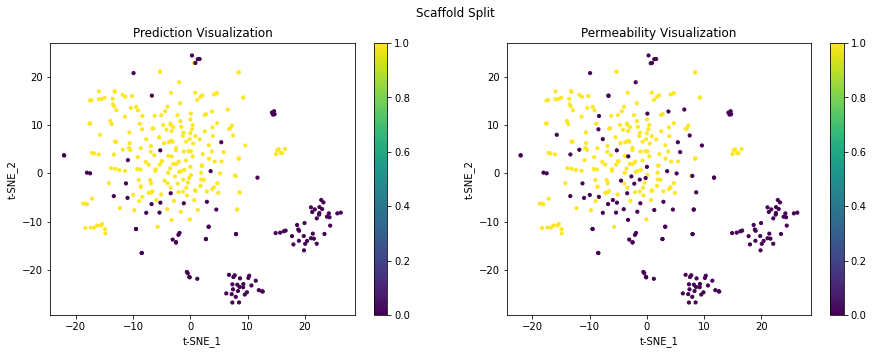

In [24]:
plot_split('Scaffold', y_pred_scaff, test_scaff.y, t_components_scaff)

## Scaffold Split Feature Importances

In [25]:
# get importance
dt_importance = SVM_best.coef_

# summarize and print out the feature importance
non_zero_index_list = [i for i, v in enumerate(dt_importance[0]) if v != 0]

# remove all zero value entries
non_zero_feature_names = [bbb_df.iloc[:,3:].columns[i] for i in non_zero_index_list]
non_zero_importance = [dt_importance[0][i] for i in non_zero_index_list]
non_zero_feature_names_str = [str(x) for x in non_zero_feature_names]
feature_importance = pd.DataFrame(list(zip(non_zero_feature_names_str, non_zero_importance)), columns =['Feature','Importance'])
feature_importance.sort_values(by='Importance', ascending=True, inplace=True)

In [26]:
feature_importance

,Feature,Importance
5,5,-0.386517
349,357,-0.325430
231,237,-0.316579
139,143,-0.304241
934,953,-0.272490
...,...,...
632,646,0.188514
134,138,0.190203
518,530,0.194462
812,828,0.208082


Text(0.5, 1.0, 'Top 10 XGBoost Feature Importances')

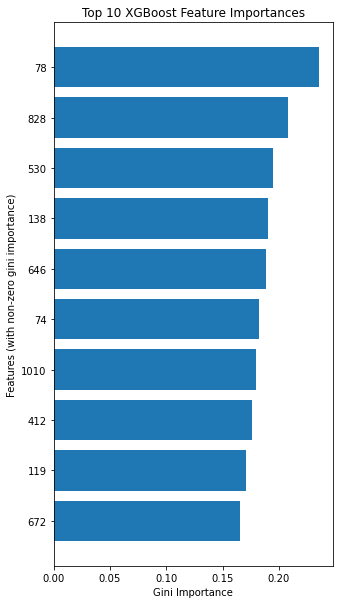

In [27]:
fig,ax = plt.subplots(figsize=(5,10))
plt.xlabel('Gini Importance')
plt.ylabel('Features (with non-zero gini importance)')
plt.barh(feature_importance['Feature'][-10:], feature_importance['Importance'][-10:])
plt.title('Top 10 XGBoost Feature Importances')